In [ ]:
import os
import zipfile

# Path to your zip file on Google Drive
zip_path = "/content/drive/MyDrive/archive.zip"

# Step 1: Unzip into /content
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Step 2: Find the extracted folder
extracted_folders = [f for f in os.listdir("/content")
                     if os.path.isdir(os.path.join("/content", f)) and f != "sample_data"]

# Step 3: Assume the first folder is our base dataset folder
if extracted_folders:
    base_path = os.path.join("/content", extracted_folders[0])
    print(f"✅ Base path set to: {base_path}")
    print("📁 Files and folders in base path:")
    print(os.listdir(base_path))
else:
    print("❌ No folders found after unzipping.")

✅ Base path set to: /content/.config
📁 Files and folders in base path:
['logs', 'config_sentinel', 'hidden_gcloud_config_universe_descriptor_data_cache_configs.db', 'gce', 'default_configs.db', '.last_update_check.json', 'active_config', '.last_opt_in_prompt.yaml', 'configurations', '.last_survey_prompt.yaml']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Scan for folders and CSVs in /content
print("📂 Folders in /content:")
for folder in os.listdir("/content"):
    full_path = os.path.join("/content", folder)
    if os.path.isdir(full_path):
        print("📁", folder)

print("\n📄 CSV files in /content:")
for file in os.listdir("/content"):
    if file.endswith(".csv"):
        print("📄", file)


📂 Folders in /content:
📁 .config
📁 images
📁 masks
📁 drive
📁 sample_data

📄 CSV files in /content:
📄 GroundTruth.csv


In [ ]:
import os
import pandas as pd

# Base path is simply /content because all files/folders are directly inside it
base_path = "/content"
metadata_path = os.path.join(base_path, "GroundTruth.csv")
image_dir = os.path.join(base_path, "images")
mask_dir = os.path.join(base_path, "masks")  # if you plan to use segmentation masks

# Check the paths
print(f"📌 Base path set to: {base_path}")
print(f"📄 Metadata path: {metadata_path}")
print(f"🖼️ Image directory: {image_dir}")
print(f"🗺️ Mask directory: {mask_dir}")

# Load metadata
metadata = pd.read_csv(metadata_path)

# Extract one-hot encoded labels to a single label column
label_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
metadata['dx'] = metadata[label_cols].idxmax(axis=1)

# Encode labels
labels = sorted(metadata['dx'].unique())
label_to_index = {name: idx for idx, name in enumerate(labels)}
metadata['label_idx'] = metadata['dx'].map(label_to_index)

print("✅ Labels:", labels)
print("✅ Metadata sample:")
print(metadata.head())


📌 Base path set to: /content
📄 Metadata path: /content/GroundTruth.csv
🖼️ Image directory: /content/images
🗺️ Mask directory: /content/masks
✅ Labels: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
✅ Metadata sample:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC   dx  label_idx
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0   NV          5
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0   NV          5
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0   NV          5
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0   NV          5
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0  MEL          4


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📌 Using device:", device)

# === Paths from your setup ===
base_path = "/content"
metadata_path = os.path.join(base_path, "GroundTruth.csv")
image_dir = os.path.join(base_path, "images")

# === Load and prepare metadata ===
metadata = pd.read_csv(metadata_path)
label_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
metadata['dx'] = metadata[label_cols].idxmax(axis=1)
labels = sorted(metadata['dx'].unique())
label_to_index = {name: idx for idx, name in enumerate(labels)}
metadata['label_idx'] = metadata['dx'].map(label_to_index)
metadata['image_path'] = metadata['image'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

📌 Using device: cuda


In [ ]:
# === Train-Validation-Test Split ===
train_df, temp_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label_idx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_idx'], random_state=42)

In [ ]:
# === Dataset Class ===
class SkinLesionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.df.loc[idx, 'image_path']).convert("RGB")
        label = self.df.loc[idx, 'label_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

# === Image Transforms ===
image_size = 224  # ConvNeXt default
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_eval = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# === Dataloaders ===
batch_size = 32
train_loader = DataLoader(SkinLesionDataset(train_df, transform_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(SkinLesionDataset(val_df, transform_eval), batch_size=batch_size)
test_loader = DataLoader(SkinLesionDataset(test_df, transform_eval), batch_size=batch_size)


In [ ]:
# === ConvNeXtV2 Model ===
model = timm.create_model('convnextv2_base.fcmae_ft_in1k', pretrained=True, num_classes=len(labels))
model = model.to(device)

# === Loss and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

In [ ]:
# === Training Function ===
def train_model(model, train_loader, val_loader, epochs=30):
    best_val_loss = float('inf')
    best_model_saved = False

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        print(f"✅ Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_modelcvn.pth")
            print("🎯 Best model saved!")
            best_model_saved = True

    # Save final model if best was never saved
    if not best_model_saved:
        torch.save(model.state_dict(), "best_modelcvn.pth")
        print("⚠️ No improvement, but final model saved as fallback.")

# === Train the model ===
train_model(model, train_loader, val_loader, epochs=30)

# ✅ Download the model file AFTER training
import os
from google.colab import files

if os.path.exists("best_modelcvn.pth"):
    files.download("best_modelcvn.pth")
else:
    print("❌ Model file not found for download.")

# === Evaluation ===
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

target_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("🔍 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
    plt.yticks(np.arange(len(target_names)), target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# === Load Best Model and Evaluate ===
model.load_state_dict(torch.load("best_modelcvn.pth"))
evaluate(model, test_loader)


Epoch 1/30 Training: 100%|██████████| 251/251 [07:53<00:00,  1.89s/it]


✅ Epoch 1: Train Loss=0.9990, Val Loss=0.9652, Train Acc=0.6767, Val Acc=0.6893
🎯 Best model saved!


Epoch 2/30 Training: 100%|██████████| 251/251 [07:38<00:00,  1.83s/it]


✅ Epoch 2: Train Loss=0.8490, Val Loss=0.8797, Train Acc=0.6995, Val Acc=0.6953
🎯 Best model saved!


Epoch 3/30 Training: 100%|██████████| 251/251 [07:34<00:00,  1.81s/it]


✅ Epoch 3: Train Loss=0.7644, Val Loss=0.7312, Train Acc=0.7275, Val Acc=0.7363
🎯 Best model saved!


Epoch 4/30 Training: 100%|██████████| 251/251 [07:36<00:00,  1.82s/it]


✅ Epoch 4: Train Loss=0.6991, Val Loss=0.6355, Train Acc=0.7454, Val Acc=0.7732
🎯 Best model saved!


Epoch 5/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 5: Train Loss=0.6414, Val Loss=0.5769, Train Acc=0.7712, Val Acc=0.7782
🎯 Best model saved!


Epoch 6/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 6: Train Loss=0.5646, Val Loss=0.5689, Train Acc=0.7902, Val Acc=0.7942
🎯 Best model saved!


Epoch 7/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 7: Train Loss=0.5218, Val Loss=0.5493, Train Acc=0.8087, Val Acc=0.7952
🎯 Best model saved!


Epoch 8/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 8: Train Loss=0.4698, Val Loss=0.5254, Train Acc=0.8310, Val Acc=0.7962
🎯 Best model saved!


Epoch 9/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 9: Train Loss=0.4339, Val Loss=0.5220, Train Acc=0.8382, Val Acc=0.8072
🎯 Best model saved!


Epoch 10/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 10: Train Loss=0.3948, Val Loss=0.5248, Train Acc=0.8523, Val Acc=0.8022


Epoch 11/30 Training: 100%|██████████| 251/251 [07:34<00:00,  1.81s/it]


✅ Epoch 11: Train Loss=0.3728, Val Loss=0.4737, Train Acc=0.8611, Val Acc=0.8432
🎯 Best model saved!


Epoch 12/30 Training: 100%|██████████| 251/251 [07:34<00:00,  1.81s/it]


✅ Epoch 12: Train Loss=0.3409, Val Loss=0.4810, Train Acc=0.8767, Val Acc=0.8402


Epoch 13/30 Training: 100%|██████████| 251/251 [07:34<00:00,  1.81s/it]


✅ Epoch 13: Train Loss=0.2946, Val Loss=0.5682, Train Acc=0.8884, Val Acc=0.8122


Epoch 14/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 14: Train Loss=0.2593, Val Loss=0.5249, Train Acc=0.9073, Val Acc=0.8332


Epoch 15/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 15: Train Loss=0.2401, Val Loss=0.5268, Train Acc=0.9111, Val Acc=0.8192


Epoch 16/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.81s/it]


✅ Epoch 16: Train Loss=0.2014, Val Loss=0.5279, Train Acc=0.9260, Val Acc=0.8312


Epoch 17/30 Training: 100%|██████████| 251/251 [07:34<00:00,  1.81s/it]


✅ Epoch 17: Train Loss=0.1778, Val Loss=0.5834, Train Acc=0.9383, Val Acc=0.8192


Epoch 18/30 Training: 100%|██████████| 251/251 [07:35<00:00,  1.82s/it]


✅ Epoch 18: Train Loss=0.1469, Val Loss=0.5394, Train Acc=0.9490, Val Acc=0.8262


Epoch 19/30 Training:  67%|██████▋   | 169/251 [05:07<02:28,  1.81s/it]

In [ ]:
# === Training Function ===
def train_model(model, train_loader, val_loader, epochs=30):
    best_val_loss = float('inf')
    best_model_saved = False

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        print(f"✅ Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_modelcvn.pth")
            print("🎯 Best model saved!")
            best_model_saved = True

    # Save final model if best was never saved
    if not best_model_saved:
        torch.save(model.state_dict(), "best_modelcvn.pth")
        print("⚠️ No improvement, but final model saved as fallback.")

# === Train the model ===
train_model(model, train_loader, val_loader, epochs=30)

# ✅ Download the model file AFTER training
import os
from google.colab import files

if os.path.exists("best_modelcvn.pth"):
    files.download("best_modelcvn.pth")
else:
    print("❌ Model file not found for download.")

# === Evaluation ===
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

target_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("🔍 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
    plt.yticks(np.arange(len(target_names)), target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# === Load Best Model and Evaluate ===
model.load_state_dict(torch.load("best_modelcvn.pth"))
evaluate(model, test_loader)


Epoch 1/30 Training: 100%|██████████| 251/251 [08:11<00:00,  1.96s/it]


✅ Epoch 1: Train Loss=0.7795, Val Loss=0.6820, Train Acc=0.7295, Val Acc=0.7682
🎯 Best model saved!


Epoch 2/30 Training: 100%|██████████| 251/251 [08:01<00:00,  1.92s/it]


✅ Epoch 2: Train Loss=0.5119, Val Loss=0.4891, Train Acc=0.8189, Val Acc=0.8412
🎯 Best model saved!


Epoch 3/30 Training: 100%|██████████| 251/251 [07:57<00:00,  1.90s/it]


✅ Epoch 3: Train Loss=0.3872, Val Loss=0.4560, Train Acc=0.8632, Val Acc=0.8412
🎯 Best model saved!


Epoch 4/30 Training: 100%|██████████| 251/251 [07:54<00:00,  1.89s/it]


✅ Epoch 4: Train Loss=0.2744, Val Loss=0.5115, Train Acc=0.9006, Val Acc=0.8382


Epoch 5/30 Training: 100%|██████████| 251/251 [07:53<00:00,  1.89s/it]


✅ Epoch 5: Train Loss=0.2110, Val Loss=0.5046, Train Acc=0.9236, Val Acc=0.8352


Epoch 6/30 Training: 100%|██████████| 251/251 [07:55<00:00,  1.89s/it]


✅ Epoch 6: Train Loss=0.1805, Val Loss=0.4170, Train Acc=0.9358, Val Acc=0.8541
🎯 Best model saved!


Epoch 7/30 Training: 100%|██████████| 251/251 [07:55<00:00,  1.89s/it]


✅ Epoch 7: Train Loss=0.1504, Val Loss=0.4599, Train Acc=0.9461, Val Acc=0.8611


Epoch 8/30 Training: 100%|██████████| 251/251 [07:56<00:00,  1.90s/it]


✅ Epoch 8: Train Loss=0.0998, Val Loss=0.4785, Train Acc=0.9675, Val Acc=0.8721


Epoch 9/30 Training: 100%|██████████| 251/251 [07:55<00:00,  1.90s/it]


✅ Epoch 9: Train Loss=0.0794, Val Loss=0.3849, Train Acc=0.9737, Val Acc=0.8911
🎯 Best model saved!


Epoch 10/30 Training:  98%|█████████▊| 247/251 [07:49<00:07,  1.88s/it]

🔍 Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.65      0.75      0.70        32
         BCC       0.86      0.81      0.83        52
         BKL       0.82      0.68      0.74       110
          DF       0.90      0.82      0.86        11
         MEL       0.75      0.59      0.66       112
          NV       0.91      0.97      0.94       671
        VASC       0.93      0.93      0.93        14

    accuracy                           0.88      1002
   macro avg       0.83      0.79      0.81      1002
weighted avg       0.87      0.88      0.87      1002



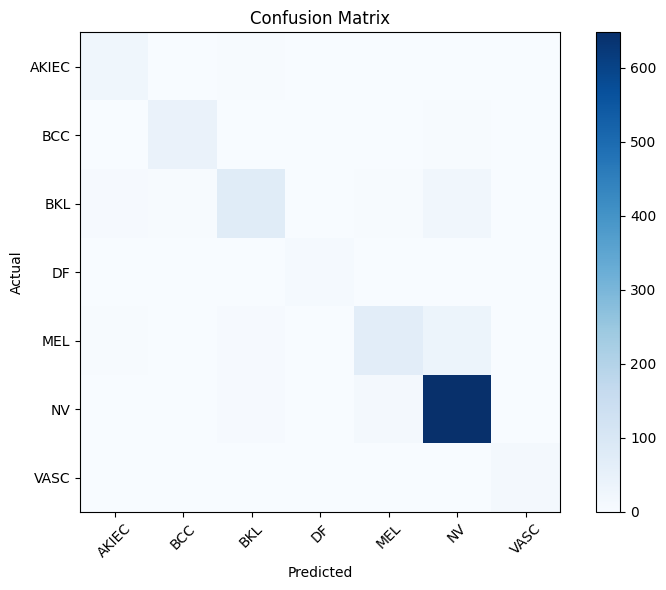

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the correct target class names in the order you used in training
target_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# === Evaluation Function ===
def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print classification report
    print("🔍 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
    plt.yticks(np.arange(len(target_names)), target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# === Load Best Model and Evaluate ===
model.load_state_dict(torch.load("best_model.pth"))
evaluate(model, test_loader)


In [ ]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.7 MB/s eta 0:00:00
